<a href="https://colab.research.google.com/github/yomyaykya/yomyay/blob/master/%D0%9F%D0%98%D0%A1_%D0%94%D0%971.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/models/research')

In [3]:
!pwd

/content/models/research


In [4]:
!unzip -q '/content/protoc-3.15.8-win64.zip'

replace include/google/protobuf/wrappers.proto? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


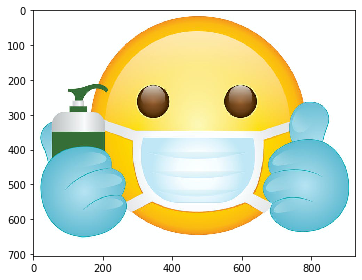

In [44]:
import numpy as np
import skimage.io as io
import pylab
import matplotlib.pyplot as plt
emoji_img =io.imread('/content/drive/MyDrive/emoji.jpg')
io.imshow(emoji_img)
io.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
## Let's convert the picture into string representation
#using the ndarray.tostring() function
emoji_string=emoji_img.tostring()
#Now let's convert the string back to the image
#Important: the dtype should be specified
#Otherwise the reconstruction will be errorless
#Reconstruction is 1d, so we need sizes of image
#to fully reconstruct it.
reconstructed_emoji_1d=np.fromstring(emoji_string, dtype=np.uint8)

#Here we reshape the 1d representation
#This is the why we need to store the sizes of image
#along with its serialized representation.
reconstructed_emoji_img=reconstructed_emoji_1d.reshape(emoji_img.shape)

#Let's check if we got everything right and compare
# reconstructed array to the original one.
np.allclose(emoji_img,reconstructed_emoji_img)

NameError: ignored

In [8]:
# Get some image/annotation pairs for example 
filename_pairs = [
('/content/VOCdevkit/VOC2007/JPEGImages/000032.jpg',
'/content/VOCdevkit/VOC2007/SegmentationClass/000032.png'),
('/content/VOCdevkit/VOC2007/JPEGImages/000039.jpg',
'/content/VOCdevkit/VOC2007/SegmentationClass/000039.png'),
('/content/VOCdevkit/VOC2007/JPEGImages/000063.jpg',
'/content/VOCdevkit/VOC2007/SegmentationClass/000063.png')
                 ]

In [9]:
# Important: We are using PIL to read .png files later.
# This was done on purpose to read indexed png files
# in a special way -- only indexes and not map the indexes
# to actual rgb values. This is specific to PASCAL VOC
# dataset data. If you don't want thit type of behaviour
# consider using skimage.io.imread()
from PIL import Image
import numpy as np
import skimage.io as io
import tensorflow as tf


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfrecords_filename = 'pascal_voc_segmentation.tfrecords'

writer = tf.io.TFRecordWriter(tfrecords_filename)

# Let's collect the real images to later on compare
# to the reconstructed ones
original_images = []

for img_path, annotation_path in filename_pairs:
    
    img = np.array(Image.open(img_path))
    annotation = np.array(Image.open(annotation_path))
    
    # The reason to store image sizes was demonstrated
    # in the previous example -- we have to know sizes
    # of images to later read raw serialized string,
    # convert to 1d array and convert to respective
    # shape that image used to have.
    height = img.shape[0]
    width = img.shape[1]
    
    # Put in the original images into array
    # Just for future check for correctness
    original_images.append((img, annotation))
    
    img_raw = img.tostring()
    annotation_raw = annotation.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'mask_raw': _bytes_feature(annotation_raw)}))
    
    writer.write(example.SerializeToString())

writer.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


In [10]:
reconstructed_images = []

record_iterator = tf.compat.v1.io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    annotation_string = (example.features.feature['mask_raw']
                                .bytes_list
                                .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    annotation_1d = np.fromstring(annotation_string, dtype=np.uint8)
    
    # Annotations don't have depth (3rd dimension)
    reconstructed_annotation = annotation_1d.reshape((height, width))
    
    reconstructed_images.append((reconstructed_img, reconstructed_annotation))

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [11]:
# Let's check if the reconstructed images match
# the original images

for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
    
    img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,
                                                          reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*annotation_pair_to_compare))


True
True
True
True
True
True


In [24]:
%matplotlib inline
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras import applications

import tensorflow as tf
import skimage.io as io

IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384

tfrecords_filename = 'pascal_voc_segmentation.tfrecords'

def read_and_decode(filename_queue):
    
    reader = tf.compat.v1.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.compat.v1.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.compat.v1.FixedLenFeature([], tf.int64),
        'width': tf.compat.v1.FixedLenFeature([], tf.int64),
        'image_raw': tf.compat.v1.FixedLenFeature([], tf.string),
        'mask_raw': tf.compat.v1.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.compat.v1.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.compat.v1.decode_raw(features['mask_raw'], tf.uint8)
    
    height = tf.compat.v1.cast(features['height'], tf.int32)
    width = tf.compat.v1.cast(features['width'], tf.int32)
    
    image_shape = tf.stack([height, width, 3])
    annotation_shape = tf.stack([height, width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_with_crop_or_pad(image=annotation,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    
    images, annotations = tf.compat.v1.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=2,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    return images, annotations

(384, 384, 3)
current batch


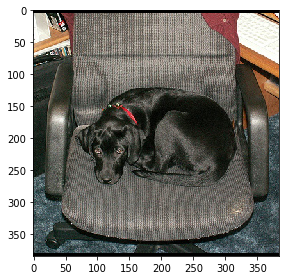

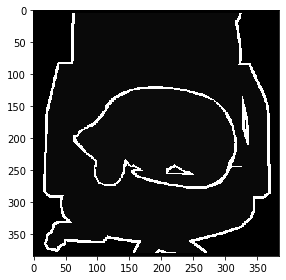

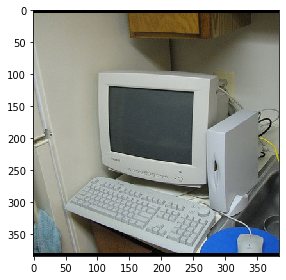

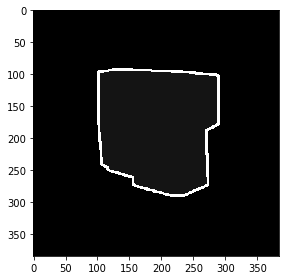

(384, 384, 3)
current batch


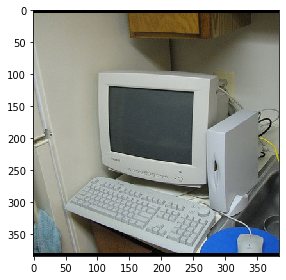

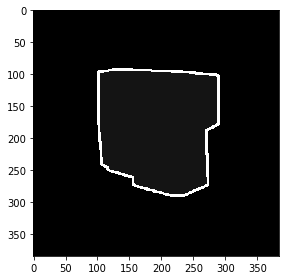

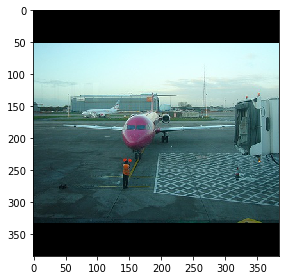

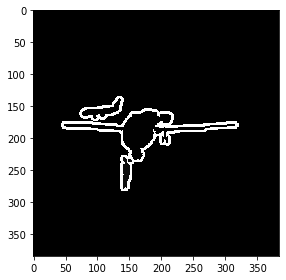

(384, 384, 3)
current batch


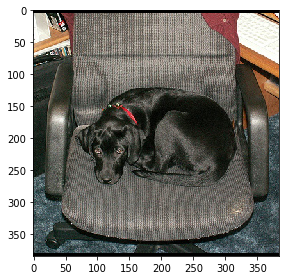

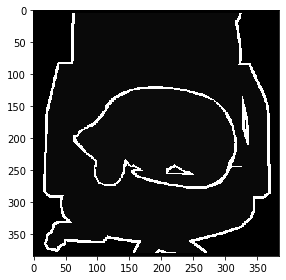

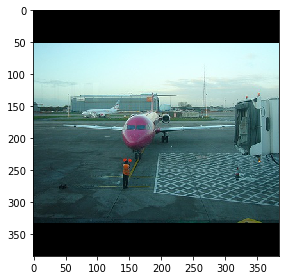

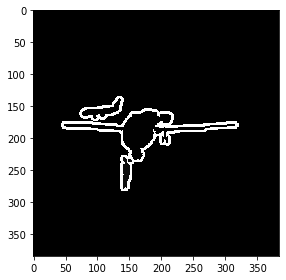

In [29]:
filename_queue =  tf.compat.v1.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                   tf.compat.v1.local_variables_initializer())

with tf.compat.v1.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.compat.v1.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(3):
    
        img, anno = sess.run([image, annotation])
        print(img[0, :, :, :].shape)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        io.imshow(img[0, :, :, :])
        io.show()

        io.imshow(anno[0, :, :, 0])
        io.show()
        
        io.imshow(img[1, :, :, :])
        io.show()

        io.imshow(anno[1, :, :, 0])
        io.show()
        
    
    coord.request_stop()
    coord.join(threads)


# New Section